In [ ]:
import numpy as np
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statistics as st
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler
import pickle
from scipy.signal import butter, lfilter

import random
from scipy.fft import fft
import os

#feature selection variance based
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

#feature selection tree based
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from tensorflow.python import keras
from keras import backend as K
import tensorflow as tf

In [ ]:
# Run on Colab

from google.colab import drive
drive.mount('/content/drive')
datasets_path = "/content/drive/MyDrive/CI_Dataset/Phase3/Datasets/"

Mounted at /content/drive


In [ ]:
# # Run for Pycharm
# datasets_path = "DataSet/Datasets/"

In [ ]:
seed = 57

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

sampling_rate = 256
target = 2000

In [ ]:
def featured(x1):
    result = np.zeros((x1.shape[0], 15))
    for i in range(len(x1)):
        #statistical features
        result[i][0] = np.mean(x1[i])
        result[i][1] = np.var(x1[i])
        result[i][2] = np.std(x1[i])
        result[i][3] = skew(x1[i])
        result[i][4] = kurtosis(x1[i])
        result[i][5] = np.max(x1[i])
        result[i][6] = np.min(x1[i])
        result[i][7] = np.median(x1[i])
        result[i][8] = st.mode(x1[i])
        #time domain features
        result[i][9] = np.ptp(x1[i])
        result[i][10] = np.mean(np.absolute(x1[i] - np.mean(x1[i])))
        #frequency domain features
        ft = fft(x1[i])
        s = np.abs(ft ** 2) / x1.shape[0]
        result[i][11] = np.max(s)
        result[i][12] = np.sum(s)
        result[i][13] = np.mean(s)
        result[i][14] = np.var(s)

    return result


In [ ]:
def normalzie(data):
    x_normalized = np.zeros_like(data)
    scaler = MinMaxScaler()
    for i in range(data.shape[1]):
        x_normalized[:, i] = scaler.fit_transform(data[:, i].reshape(-1, 1)).flatten()
    return x_normalized

In [ ]:
def prepare_data(data_file_path_number):
  target = 2000

  # Read Dataset
  data_points_channel_1 = pickle.load(open(datasets_path + str(data_file_path_number) + '/data_points_channel_1.pkl', 'rb'))
  data_points_channel_2 = pickle.load(open(datasets_path + str(data_file_path_number) + '/data_points_channel_2.pkl', 'rb'))
  labels = pickle.load(open(datasets_path + str(data_file_path_number) + '/labels.pkl', 'rb'))

  # Filter Data Points
  b, a = butter(3, [0.5, 40], btype='bandpass', fs=sampling_rate)

  data_points_channel_1_filtered = np.array([lfilter(b, a, data_points_channel_1[ind, :]) for ind in range(data_points_channel_1.shape[0])])
  data_points_channel_2_filtered = np.array([lfilter(b, a, data_points_channel_2[ind, :]) for ind in range(data_points_channel_2.shape[0])])

  featured_data_ch1 = featured(data_points_channel_1_filtered)
  featured_data_ch2 = featured(data_points_channel_2_filtered)
  normal_featured_data_ch1 = normalzie(featured_data_ch1)
  normal_featured_data_ch2 = normalzie(featured_data_ch2)

  normal_data_ch1 = normalzie(data_points_channel_1_filtered)
  normal_data_ch2 = normalzie(data_points_channel_2_filtered)

  data_raw = []
  data_raw.append([])
  data_raw.append([])

  data_raw[0] = normal_data_ch1
  data_raw[1] = normal_data_ch2

  data_raw = np.array(data_raw)
  
  features_concat = np.concatenate((normal_featured_data_ch1, normal_featured_data_ch2), axis=0)
  labels_cat = np.concatenate((labels, labels), axis=0)

  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(features_concat, labels_cat)
  clf.feature_importances_

  model = SelectFromModel(clf, prefit=True)
  data_featured = model.transform(features_concat)

  data_featured = np.concatenate((data_featured[:target], data_featured[target:]), axis=1)

  x, y, z = data_raw.shape
  data_raw_new = np.zeros((y, z, x))

  for i in range(y):
    for j in range(z):
      for k in range(x):
        data_raw_new[i][j][k] = data_raw[k][i][j]

  return data_raw_new, data_featured, labels

In [ ]:
data_points, featured_data_points, labels = prepare_data(1)

In [ ]:
def data_split(data, label, feature):
    indices = np.arange(target)
    indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=seed)

    data_test = data[indices_test]
    label_test = label[indices_test]
    feature_test = feature[indices_test]

    indices_train_train, indices_train_val = train_test_split(indices_train, test_size=0.25, random_state=seed)

    data_train = data[indices_train_train]
    label_train = label[indices_train_train]
    feature_train = feature[indices_train_train]

    data_val = data[indices_train_val]
    label_val = label[indices_train_val]
    feature_val = feature[indices_train_val]

    return data_train, label_train, feature_train, data_test, label_test, feature_test, data_val, label_val, feature_val

In [ ]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def cnn(filter1,filter2,kernel1,kernel2,dense1,dense2, data_raw_new, data_featured, data_points_train, features_train, labels_train, data_points_val, features_val, labels_val, data_points_test, features_test, labels_test):
    # 60,60,4,4,100,20
    input1 = tf.keras.Input(shape=data_raw_new[0].shape, name="first datas")
    input2 = tf.keras.Input(shape=data_featured[0].shape, name="featured datas")

    model1 = tf.keras.layers.Conv1D(filters=filter1, kernel_size=kernel1, activation='relu',name='convolution_layer1')(input1)
    model1 = tf.keras.layers.MaxPool1D(pool_size=2,name='pooling_layer1')(model1)


    model1 = tf.keras.layers.Conv1D(filters=filter2, kernel_size=kernel2, activation='relu',name='convolution_layer2')(model1)
    model1 = tf.keras.layers.MaxPool1D(pool_size=2,name='pooling_layer2')(model1)

    # model1 = tf.keras.layers.Conv1D(filters=60, kernel_size=4, activation='relu',name='convolution_layer3')(model1)
    # model1 = tf.keras.layers.MaxPool1D(pool_size=2,name='pooling_layer3')(model1)


    model1 = tf.keras.layers.Flatten(name='flatten_layer')(model1)

    model1 = tf.keras.layers.Dense(dense1, activation="relu",name='Dense_layer1')(model1)


    model1 = tf.keras.layers.Dense(dense2, activation="relu",name='Dense_layer_cnnfeatures')(model1)


    model2 = tf.keras.layers.Dense(data_featured.shape[1], activation="relu",name='Dense_layer_selectedfeature', trainable=False)(input2)

    concat = tf.keras.layers.Concatenate()([model1, model2])

    result = tf.keras.layers.Dense(2, activation="softmax",name='output_layer')(concat)

    model_final = tf.keras.Model([input1, input2], result)

    model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc",f1_m,precision_m, recall_m])
    # model_final.summary()
    res = model_final.fit([data_points_train, features_train], y=labels_train, batch_size=20, epochs=5,
                          validation_data=([data_points_val, features_val], labels_val))
    
    return model_final, res

In [ ]:
def implement_model(data_raw_new, data_featured, labels):
  categorical_label=np.zeros((len(labels),2),int)
  for i in range(labels.shape[0]):
    if labels[i]==0:
      categorical_label[i]=np.array((0,1),int)
    if labels[i]==1:
      categorical_label[i]=np.array((1,0),int)

  result = data_split(data_raw_new, categorical_label, data_featured)
  data_points_train, labels_train, features_train, data_points_test, labels_test, features_test, data_points_val, labels_val, features_val = result

  model_final, res = cnn(60,60,4,4,100,20, data_raw_new, data_featured, data_points_train, features_train, labels_train, data_points_val, features_val, labels_val, data_points_test, features_test, labels_test)

  return data_points_test, model_final, features_test, labels_test, res

In [ ]:
data_points_test, model_final, features_test, labels_test, res = implement_model(data_points, featured_data_points, labels)

Epoch 1/5
60/60 [==============================] - 6s 84ms/step - loss: 0.6676 - acc: 0.5833 - f1_m: 0.5833 - precision_m: 0.5833 - recall_m: 0.5833 - val_loss: 0.6250 - val_acc: 0.7200 - val_f1_m: 0.7200 - val_precision_m: 0.7200 - val_recall_m: 0.7200
Epoch 2/5
60/60 [==============================] - 8s 138ms/step - loss: 0.6512 - acc: 0.6108 - f1_m: 0.6108 - precision_m: 0.6108 - recall_m: 0.6108 - val_loss: 0.5870 - val_acc: 0.6450 - val_f1_m: 0.6450 - val_precision_m: 0.6450 - val_recall_m: 0.6450
Epoch 3/5
60/60 [==============================] - 5s 78ms/step - loss: 0.5864 - acc: 0.6742 - f1_m: 0.6742 - precision_m: 0.6742 - recall_m: 0.6742 - val_loss: 0.6744 - val_acc: 0.6075 - val_f1_m: 0.6075 - val_precision_m: 0.6075 - val_recall_m: 0.6075
Epoch 4/5
60/60 [==============================] - 5s 75ms/step - loss: 0.5803 - acc: 0.6883 - f1_m: 0.6883 - precision_m: 0.6883 - recall_m: 0.6883 - val_loss: 0.6164 - val_acc: 0.5250 - val_f1_m: 0.5250 - val_precision_m: 0.5250 - val_

In [ ]:
def view_results(data_points_test, model_final, features_test, labels_test, res):
  print(data_points_test.shape)
  hi= model_final.evaluate(x=[data_points_test,features_test],y=labels_test,verbose=0)
  print(hi)

  accuracy=res.history['acc']
  value_accuracy=res.history['val_acc']
  loss=res.history['loss']
  value_loss=res.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(accuracy, label='Training Accuracy')
  plt.plot(value_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()), 1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(value_loss, label='Validation Loss')
  # plt.plot(triplet_loss, label='Training Triplet Loss')
  # plt.plot(triplet_val_loss, label='Validation Triplet Loss')
  plt.legend(loc='lower left')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

(400, 1280, 2)
[0.5298411846160889, 0.7749999761581421, 0.7716345191001892, 0.7716346383094788, 0.7716346383094788]


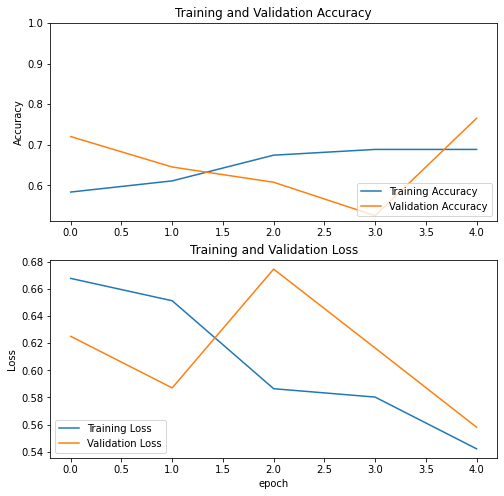

In [ ]:
view_results(data_points_test, model_final, features_test, labels_test, res)